<a href="https://colab.research.google.com/github/jmamath/learning-approximate-invariance-requires-far-fewer-data/blob/master/Estimate_Uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emnist

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import time

import torch
from torch.distributions import Normal
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from tqdm import trange
 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import seaborn as sns
import imgaug
from keras.datasets import fashion_mnist
from imgaug import augmenters as iaa
from keras.utils import np_utils
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Memory profiling
import psutil
import sys

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

# device = 'cpu'
print(device)

In [ ]:
from emnist import list_datasets
list_datasets()


In [ ]:
from emnist import extract_training_samples
images, labels = extract_training_samples('letters')


In [ ]:
plt.imshow(images[2])
plt.title("{}".format(labels[2]))

In [ ]:
mask_a = labels == 1
mask_b = labels == 2
mask_c = labels == 3
mask_d = labels == 4
mask_e = labels == 5
mask_f = labels == 6
mask_g = labels == 7
mask_h = labels == 8
mask_i = labels == 9
mask_j = labels == 10

In [ ]:
data_a = images[mask_a]
data_b = images[mask_b]
data_c = images[mask_c]
data_d = images[mask_d]
data_e = images[mask_e]
data_f = images[mask_f]
data_g = images[mask_g]
data_h = images[mask_h]
data_i = images[mask_i]
data_j = images[mask_j]



In [ ]:
label_a = labels[mask_a]
label_b = labels[mask_b]
label_c = labels[mask_c]
label_d = labels[mask_d]
label_e = labels[mask_e]
label_f = labels[mask_f]
label_g = labels[mask_g]
label_h = labels[mask_h]
label_i = labels[mask_i]
label_j = labels[mask_j]

In [ ]:
dataset = np.concatenate([data_a, data_b, data_c,
                          data_d, data_e, data_f,
                          data_g, data_h, data_i,
                          data_j], axis=0)

labels_ = np.concatenate([label_a, label_b, label_c,
                          label_d, label_e, label_f,
                          label_g, label_h, label_i,
                          label_j], axis=0)

In [ ]:
data_a.shape

(4800, 28, 28)

In [ ]:
dataset = dataset.astype(np.float32)
dataset /= 255
labels_ = labels_.astype(np.int64)

In [ ]:
# @title Dataset class
class MyData(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels, display):
        'Initialization'
        self.labels = labels
        self.data = data 
        self.display = display     

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.data[index]            
        # Load data and get label
        y = self.labels[index] 
        if self.display:       
          return X,y       
        else:
          # import pdb; pdb.set_trace()
          return X.reshape(-1), y

In [ ]:
new_data = MyData(dataset,labels_, display=True)
loader_basic = DataLoader(new_data,batch_size=128,shuffle=True)


In [ ]:
enum_data = enumerate(loader_basic)
_, (data, label) = next(enum_data)
data = data.cpu()

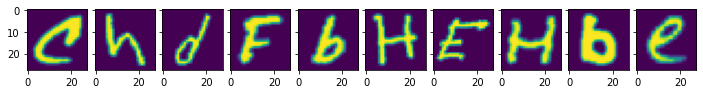

In [ ]:
fig = plt.figure(figsize=(12., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 10),  # creates 4x3 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, data[:10]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

## Compute the Empirical Entropy Cumulative Distribution

In [ ]:
my_data = MyData(dataset,labels_, display=False)
testloader = DataLoader(my_data,batch_size=1024,shuffle=False)



In [ ]:
enum_data = enumerate(testloader)
_, (data, label) = next(enum_data)
data = data.cpu()


In [ ]:
data.max()

tensor(1., device='cpu')

In [ ]:
print(data.shape)
print(label.dtype)
print(data.dtype)

torch.Size([1024, 784])
torch.int64
torch.float32


In [ ]:
from classes import *
vanilla = torch.load("vanilla")
online_da_rotation = torch.load("online_da_rotation")
offline_da_rotation = torch.load("offline_da_rotation")
invariant_prior_rotation = torch.load("invariant_prior_rotation")

online_da_noise = torch.load("online_da_noise")
offline_da_noise = torch.load("offline_da_noise")
invariant_prior_noise = torch.load("invariant_prior_noise")

online_da_rot_noise = torch.load("online_da_rot_noise")
offline_da_rot_noise = torch.load("offline_da_rotation_noise")
invariant_prior_rot_noise = torch.load("invariant_prior_rotation_noise")



In [ ]:
def compute_accuracy(pred, y):
  _, predicted = torch.max(F.softmax(pred), 1)
  total = len(pred)
  correct = (predicted == y).sum()
  accuracy = 100 * correct.cpu().numpy() / total
  return accuracy

def evaluate_model(model, loader, repetition):
  all_accuracies = np.zeros(repetition)
  for i in range(repetition):
    acc_final = []
    for x, y in loader: # batch_level
      # import pdb; pdb.set_trace()
      x = x.to(device).squeeze().reshape(len(x),-1)
      y = y.to(device)
      # import pdb; pdb.set_trace()
      predictions = torch.zeros(100,len(x),10)
      for j in range(100):
        predictions[j] = model(x)
      pred = predictions.mean(0)
      accuracy = compute_accuracy(pred, y)
      acc_final.append(accuracy)
    all_accuracies[i] = np.array(acc_final).mean()
  return all_accuracies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
all_acc_vanilla = evaluate_model(vanilla, testloader, 10)
all_acc_online_da_rot = evaluate_model(online_da_rotation, testloader, 10)
all_acc_offline_da_rot = evaluate_model(offline_da_rotation, testloader, 10)
all_acc_inv_prior_rot = evaluate_model(invariant_prior_rotation, testloader, 10)

acc_mean_vanilla = round(all_acc_vanilla.mean(),1)
acc_std_vanilla = round(all_acc_vanilla.std(),1)

acc_mean_online_da_rot = round(all_acc_online_da_rot.mean(),1)
acc_std_online_da_rot = round(all_acc_online_da_rot.std(),1)

acc_mean_offline_da_rot = round(all_acc_offline_da_rot.mean(),1)
acc_std_offline_da_rot = round(all_acc_offline_da_rot.std(),1)

acc_mean_inv_prior_rot = round(all_acc_inv_prior_rot.mean(),1)
acc_std_inv_prior_rot = round(all_acc_inv_prior_rot.std(),1)


print("Vanilla final test accuracy: {} +/-{}".format(acc_mean_vanilla, acc_std_vanilla))
print("Online Da Rotation final test accuracy: {} +/-{}".format(acc_mean_online_da_rot, acc_std_online_da_rot))
print("Offline Da Rotation final test accuracy: {} +/-{}".format(acc_mean_offline_da_rot, acc_std_offline_da_rot))
print("Invariant prior final test accuracy: {} +/-{}".format(acc_mean_inv_prior_rot, acc_std_inv_prior_rot))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Vanilla final test accuracy: 6.8 +/-0.1
Online Da Rotation final test accuracy: 3.9 +/-0.1
Offline Da Rotation final test accuracy: 3.8 +/-0.1
Invariant prior final test accuracy: 5.2 +/-0.1


In [ ]:
def predictive_entropy(model, loader, MC_sample):
  entropies = []
  for x,y in loader:
    probabilities = torch.zeros(MC_sample, len(x),10)
    for j in range(MC_sample):
      probabilities[j] = F.softmax(model(x.to(device)))
    # import pdb; pdb.set_trace()
    probs = probabilities.mean(0)
    # Convention: 0 * log(0) = 0
    zero_probs = probs == 0
    log_probs = probs.log()
    log_probs[zero_probs] = 0    
    entropy = -(probs * log_probs).sum(-1)  
    entropies.append(entropy.cpu().detach().numpy())
  return np.concatenate(entropies)
         

In [ ]:
t = torch.Tensor([[0.4,  0.0,  0.2,  0.4],
[0.1,  0.3,  0.4,  0.2],
[0.0,  0.0,  0.0,  1.0]])

mask = t==0
s = t.log()
s[mask]=0
-(t*s).sum(-1)


tensor([1.0549, 1.2799, -0.0000])

In [ ]:
entropies_vanilla = predictive_entropy(vanilla, testloader, MC_sample=100)

entropies_online_da_rot = predictive_entropy(online_da_rotation, testloader, MC_sample=100)
entropies_offline_da_rot = predictive_entropy(offline_da_rotation, testloader, MC_sample=100)
entropies_inv_prior_rot = predictive_entropy(invariant_prior_rotation, testloader, MC_sample=100)

entropies_online_da_noise = predictive_entropy(online_da_noise, testloader, MC_sample=100)
entropies_offline_da_noise = predictive_entropy(offline_da_noise, testloader, MC_sample=100)
entropies_inv_prior_noise = predictive_entropy(invariant_prior_noise, testloader, MC_sample=100)

entropies_online_da_rot_noise = predictive_entropy(online_da_rot_noise, testloader, MC_sample=100)
entropies_offline_da_rot_noise = predictive_entropy(offline_da_rot_noise, testloader, MC_sample=100)
entropies_inv_prior_rot_noise = predictive_entropy(invariant_prior_rot_noise, testloader, MC_sample=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
np.save("entropies_vanilla", entropies_vanilla)

np.save("entropies_online_da_rot", entropies_online_da_rot)
np.save("entropies_offline_da_rot", entropies_offline_da_rot)
np.save("entropies_inv_prior_rot", entropies_inv_prior_rot)

np.save("entropies_online_da_noise", entropies_online_da_noise)
np.save("entropies_offline_da_noise", entropies_offline_da_noise)
np.save("entropies_inv_prior_noise", entropies_inv_prior_noise)

np.save("entropies_online_da_rot_noise", entropies_online_da_rot_noise)
np.save("entropies_offline_da_rot_noise", entropies_offline_da_rot_noise)
np.save("entropies_inv_prior_rot_noise", entropies_inv_prior_rot_noise)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
print("vanilla {}".format(np.sum(np.isnan(entropies_vanilla)) / entropies_vanilla.shape[0]))

print("online rot {}".format(np.sum(np.isnan(entropies_online_da_rot)) / entropies_online_da_rot.shape[0]))
print("offline rot {}".format(np.sum(np.isnan(entropies_offline_da_rot)) / entropies_offline_da_rot.shape[0]))
print("inv rot {}".format(np.sum(np.isnan(entropies_inv_prior_rot)) / entropies_inv_prior_rot.shape[0]))

print("online noise {}".format(np.sum(np.isnan(entropies_online_da_noise)) / entropies_online_da_noise.shape[0]))
print("offline noise {}".format(np.sum(np.isnan(entropies_offline_da_noise)) / entropies_offline_da_noise.shape[0]))
print("inv noise {}".format(np.sum(np.isnan(entropies_inv_prior_noise)) / entropies_inv_prior_noise.shape[0]))

print("online rot noise {}".format(np.sum(np.isnan(entropies_online_da_rot_noise)) / entropies_online_da_rot_noise.shape[0]))
print("offline rot noise {}".format(np.sum(np.isnan(entropies_offline_da_rot_noise)) / entropies_offline_da_rot_noise.shape[0]))
print("inv rot noise {}".format(np.sum(np.isnan(entropies_inv_prior_rot_noise)) / entropies_inv_prior_rot_noise.shape[0]))

vanilla 0.0
online rot 0.0
offline rot 0.0
inv rot 0.0
online noise 0.0
offline noise 0.0
inv noise 0.0
online rot noise 0.0
offline rot noise 0.0
inv rot noise 0.0


In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

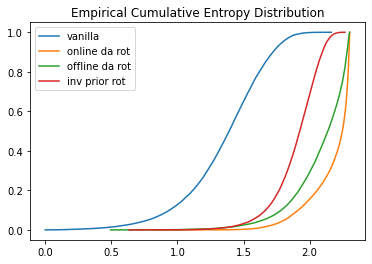

In [ ]:
# fit a cdf
ecdf_vanilla = ECDF(entropies_vanilla)
ecdf_online_da_rot = ECDF(entropies_online_da_rot)
ecdf_offline_da_rot = ECDF(entropies_offline_da_rot)
ecdf_inv_prior_rot = ECDF(entropies_inv_prior_rot)
# get cumulative probability for values
# print('P(x<20): %.3f' % ecdf(1))
# print('P(x<40): %.3f' % ecdf(2))
# print('P(x<60): %.3f' % ecdf(3))
# plot the cdf
plt.plot(ecdf_vanilla.x, ecdf_vanilla.y, label='vanilla')
plt.plot(ecdf_online_da_rot.x, ecdf_online_da_rot.y, label='online da rot')
plt.plot(ecdf_offline_da_rot.x, ecdf_offline_da_rot.y, label='offline da rot')
plt.plot(ecdf_inv_prior_rot.x, ecdf_inv_prior_rot.y, label='inv prior rot')
plt.title("Empirical Cumulative Entropy Distribution")
plt.legend()

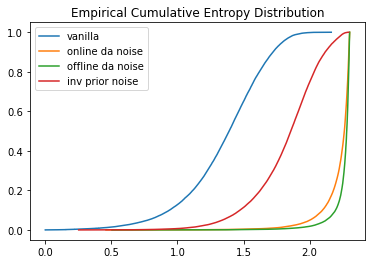

In [ ]:
# fit a cdf
ecdf_vanilla = ECDF(entropies_vanilla)
ecdf_online_da_noise = ECDF(entropies_online_da_noise)
ecdf_offline_da_noise = ECDF(entropies_offline_da_noise)
ecdf_inv_prior_noise = ECDF(entropies_inv_prior_noise)
# get cumulative probability for values
# print('P(x<20): %.3f' % ecdf(1))
# print('P(x<40): %.3f' % ecdf(2))
# print('P(x<60): %.3f' % ecdf(3))
# plot the cdf
plt.plot(ecdf_vanilla.x, ecdf_vanilla.y, label='vanilla')
plt.plot(ecdf_online_da_noise.x, ecdf_online_da_noise.y, label='online da noise')
plt.plot(ecdf_offline_da_noise.x, ecdf_offline_da_noise.y, label='offline da noise')
plt.plot(ecdf_inv_prior_noise.x, ecdf_inv_prior_noise.y, label='inv prior noise')
plt.title("Empirical Cumulative Entropy Distribution")
plt.legend()

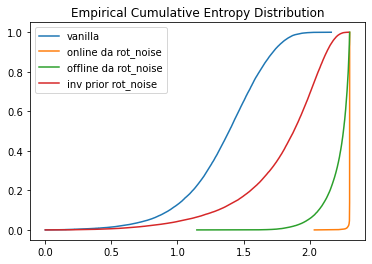

In [ ]:
# fit a cdf
ecdf_vanilla = ECDF(entropies_vanilla)
ecdf_online_da_rot_noise = ECDF(entropies_online_da_rot_noise)
ecdf_offline_da_rot_noise = ECDF(entropies_offline_da_rot_noise)
ecdf_inv_prior_rot_noise = ECDF(entropies_inv_prior_rot_noise)
# get cumulative probability for values
# print('P(x<20): %.3f' % ecdf(1))
# print('P(x<40): %.3f' % ecdf(2))
# print('P(x<60): %.3f' % ecdf(3))
# plot the cdf
plt.plot(ecdf_vanilla.x, ecdf_vanilla.y, label='vanilla')
plt.plot(ecdf_online_da_rot_noise.x, ecdf_online_da_rot_noise.y, label='online da rot_noise')
plt.plot(ecdf_offline_da_rot_noise.x, ecdf_offline_da_rot_noise.y, label='offline da rot_noise')
plt.plot(ecdf_inv_prior_rot_noise.x, ecdf_inv_prior_rot_noise.y, label='inv prior rot_noise')
plt.title("Empirical Cumulative Entropy Distribution")
plt.legend()

(array([2.000e+00, 0.000e+00, 2.000e+00, 8.000e+00, 9.000e+00, 1.700e+01,
        3.900e+01, 8.300e+01, 2.100e+02, 4.763e+04]),
 array([2.0354786, 2.0621893, 2.0888999, 2.1156106, 2.1423213, 2.169032 ,
        2.1957426, 2.2224534, 2.249164 , 2.2758746, 2.3025854],
       dtype=float32),
 <a list of 10 Patch objects>)

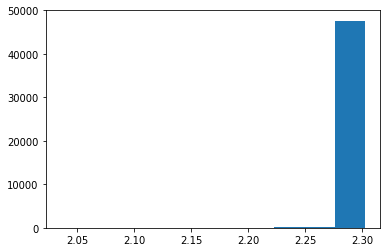

In [ ]:
plt.hist(entropies_online_da_rot_noise)

(array([1.0000e+00, 5.0000e+00, 7.0000e+00, 4.8000e+01, 2.1600e+02,
        8.6200e+02, 2.3400e+03, 4.2410e+03, 6.8550e+03, 3.3425e+04]),
 array([0.82551926, 0.97322583, 1.1209325 , 1.268639  , 1.4163456 ,
        1.5640522 , 1.7117587 , 1.8594654 , 2.0071719 , 2.1548786 ,
        2.3025851 ], dtype=float32),
 <a list of 10 Patch objects>)

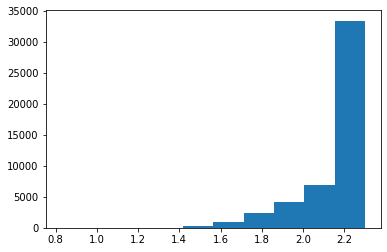

In [ ]:
plt.hist(entropies_online_da_rot)

In [ ]:
res_online = np.array([online_da_rot_noise(data[0:1].to(device)).cpu().detach().numpy() for i in range(100)]).squeeze()
res_offline = np.array([offline_da_rot_noise(data[0:1].to(device)).cpu().detach().numpy() for i in range(100)]).squeeze()
res_inv = np.array([invariant_prior_rot_noise(data[0:1].to(device)).cpu().detach().numpy() for i in range(100)]).squeeze()

In [ ]:
online_rot_sample_1 = online_da_rot_noise.sample()
online_rot_sample_2 = online_da_rot_noise.sample()

In [ ]:
torch.sum(online_rot_sample_1 == online_rot_sample_2)

tensor(0)